In [1]:
import sys
sys.path.insert(1, '/home/kardashin/Work')
sys.path.insert(1, 'C:/Users/kardashin/Work')
from variationals import *

from scipy.stats import gaussian_kde, unitary_group
from scipy.linalg import logm
from numpy import outer
from numpy.linalg import eig, eigh, norm
from math import log2

import seaborn as sns

from functools import reduce
from itertools import product

import time

from qiskit import IBMQ
from qiskit.quantum_info import Operator
provider = IBMQ.load_account()
from qiskit.providers.aer.noise import NoiseModel

import matplotlib
from matplotlib import rc
matplotlib.rc('font', family='CMU Serif')
matplotlib.rcParams['mathtext.fontset'] = 'cm' 
matplotlib.rcParams['axes.unicode_minus'] = False
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [3]:
def hs_product(op1, op2):
    return trace((op1.conj().T).dot(op2))

In [300]:
def schwinger_model(n_qubits, w, m, g):
    
    d = 2**n_qubits
    
    sp = (X_np + 1j * Y_np) / 2
    sm = (X_np - 1j * Y_np) / 2
    
    term_1 = 1j * np.zeros((d, d))
    for j in range(n_qubits):
        k = (j + 1) % n_qubits
        crea = [I_np]*j + [sp] + [I_np]*(n_qubits - j - 1)
        anni = [I_np]*k + [sm] + [I_np]*(n_qubits - k - 1)
        crea = reduce(kron, crea)
        anni = reduce(kron, anni)
        op = crea.dot(anni)
        term_1 = term_1 + op + op.conj().T
    term_1 = w * term_1

    term_2 = 1j * np.zeros((d, d))
    for j in range(n_qubits):
        operator = [I_np]*j + [Z_np] + [I_np]*(n_qubits - 1 - j)
        term_2 = term_2 + (-1)**(j + 1) * reduce(kron, operator)
    term_2 = m / 2 * term_2

    term_3 = 1j * np.zeros((d, d))
    for j in range(n_qubits):
        L = 1j * np.zeros((d, d))
        for l in range(j + 1):
            operator = [I_np]*n_qubits
            operator[l] = Z_np + (-1)**(l + 1) * I_np
            L = L - 0.5 * reduce(kron, operator)
        term_3 = term_3 + L.dot(L)
    term_3 = g * term_3
        
    return term_1 + term_2 + term_3

# v0

In [4]:
n_qubits = 4
J = 1
h = 1
t = 1
k = 5

zz = expm(-1j * t/k * hamiltonian_dictionary_to_matrix(ising_model(n_qubits, J, 0)))
x = expm(-1j * t/k * hamiltonian_dictionary_to_matrix(ising_model(n_qubits, 0, h)))

u_a = reduce(np.dot, [np.dot(zz, x)]*k)
u_e = expm(-1j * t * hamiltonian_dictionary_to_matrix(ising_model(n_qubits, J, h)))

print('HS product:', abs(hs_product(u_a, u_e) / 2**n_qubits))

HS product: 0.9806410808309554


In [5]:
n_qubits = 2
n_layers = 1
J = 1
h = 1
t = 1
k = 10

zz = expm(-1j * t/k * hamiltonian_dictionary_to_matrix(ising_model(n_qubits, J, 0)))
x = expm(-1j * t/k * hamiltonian_dictionary_to_matrix(ising_model(n_qubits, 0, h)))

u_a = reduce(np.dot, [np.dot(zz, x)]*k)
u_e = expm(-1j * t * hamiltonian_dictionary_to_matrix(ising_model(n_qubits, J, h)))

statevector = np.dot( tensor_network_to_matrix(n_qubits, heas_ansatz_eff(n_qubits, n_layers)), [1] + [0]*(2**n_qubits - 1) )

cost_a = abs(statevector.conj().T.dot(u_a).dot(statevector))**2
cost_e = abs(statevector.conj().T.dot(u_e).dot(statevector))**2

print('Cost appro:', cost_a)
print('Cost exact:', cost_e)

Cost appro: 0.13458798416065376
Cost exact: 0.13318597873059768


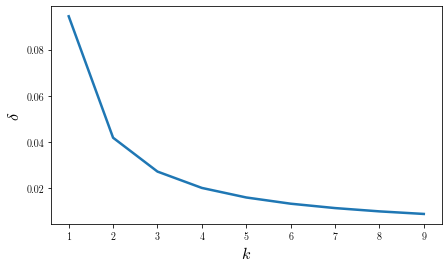

In [6]:
n_qubits = 4
n_layers = 1
t = 1
ks = [i for i in range(1, 10)]
J = 1
h = 1

u_e = expm(-1j * t * hamiltonian_dictionary_to_matrix(ising_model(n_qubits, J, h)))

n_instances = 100
seeds = random.sample(range(int(1e10)), n_instances)
state_tensor_networks = [heas_ansatz_eff(n_qubits, n_layers) for i in range(n_instances)]

zerostate = [1] + [0]*(2**n_qubits - 1)

difs = []
for k in ks:
    difs_local = []
    for i in range(n_instances):
        
        zz = expm(-1j * t/k * hamiltonian_dictionary_to_matrix(ising_model(n_qubits, J, 0)))
        x = expm(-1j * t/k * hamiltonian_dictionary_to_matrix(ising_model(n_qubits, 0, h)))
        u_a = reduce(np.dot, [np.dot(zz, x)]*k)
        
        statevector = np.dot( tensor_network_to_matrix(n_qubits, state_tensor_networks[i]), zerostate )

        cost_a = abs(statevector.conj().T.dot(u_a).dot(statevector))**2
        cost_e = abs(statevector.conj().T.dot(u_e).dot(statevector))**2
        
        p_approx = abs(statevector.conj().T.dot(u_a).dot(statevector))**2
        p_exact = abs(statevector.conj().T.dot(u_e).dot(statevector))**2
        
        
        difs_local.append(abs(p_approx - p_exact))
    difs.append(np.mean(difs_local))
    
plt.figure(figsize=(7, 4))
plt.plot(ks, difs, label='$energy$', linewidth=2.5)
plt.xlabel(r'$k$', fontsize=16)
plt.ylabel(r'$\delta$', fontsize=16)
plt.show()

# v1

In [26]:
def ising_unitary_trotter(qreg, creg, t, k, J=1, h=1):
    
    n_qubits = qreg.size
    
    T = 2 * t / k
    
    circuit = QuantumCircuit(qreg, creg)
    
    for i in range(k):
        for j in range(n_qubits - 1):
            circuit.rzz(J * T, j, j + 1)
        if n_qubits > 2:
            circuit.rzz(J * T, 0, n_qubits - 1)
        for j in range(n_qubits):
            circuit.rx(h * T, j)
    
#     ezz = expm(-1j * J * T * kron(Z_np, Z_np))
#     ex = expm(-1j * h * T * X_np)

#     for i in range(k):
#         for j in range(n_qubits - 1):
#             circuit.append(Operator(ezz), [j, j + 1])
#         if n_qubits > 2:
#             circuit.append(Operator(ezz), [0, n_qubits - 1])
#         for j in range(n_qubits):
#             circuit.append(Operator(ex), [j])
            
    return circuit

In [27]:
def ising_unitary_exact(qreg, creg, t, J=1, h=1):
    
    n_qubits = qreg.size
    
    circuit = QuantumCircuit(qreg, creg)
    matrix = expm(-1j * t * hamiltonian_dictionary_to_matrix(ising_model(n_qubits, J, h)))
    circuit.append(Operator(matrix), [i for i in range(n_qubits)])
    
    return circuit

In [28]:
def uni_cost(n_qubits, state_tensor_network, shots, t, k, J=1, h=1, seed=None):
    
    qreg = QuantumRegister(n_qubits)
    creg = ClassicalRegister(n_qubits)

    ansatz = tensor_network_to_qiskit_circuit(n_qubits, state_tensor_network, qreg, creg)
    ansatz_dg = (tensor_network_to_qiskit_circuit(n_qubits, state_tensor_network, qreg, creg)).inverse()
    
    u_circ_approx = ising_unitary_trotter(qreg, creg, t, k, J=J, h=h)
    u_circ_exact = ising_unitary_exact(qreg, creg, t, J=J, h=h) 
    
    measurer = QuantumCircuit(qreg, creg)
    for i in range(n_qubits):
        measurer.measure(i, i)
    
    circuit_approx = ansatz + u_circ_approx + ansatz_dg + measurer
    circuit_exact = ansatz + u_circ_exact + ansatz_dg + measurer
    
    job = execute([circuit_approx, circuit_exact], shots=shots, seed_simulator=seed, backend=Aer.get_backend('qasm_simulator'))   
    result = job.result()
    counts = result.get_counts()
    
    zeros_str = '0' * n_qubits
    if zeros_str in counts[0].keys():
        p0_approx = counts[0][zeros_str] / shots
    else:
        p0_approx = 0
    if zeros_str in counts[1].keys():
        p0_exact = counts[1][zeros_str] / shots
    else:
        p0_exact = 0
    
    return p0_approx, p0_exact

In [29]:
n_qubits = 4
n_layers = 3
shots = 1000
t = 1
k = 1
J = 1
h = 1

state_tensor_network = heas_ansatz_eff(n_qubits, n_layers)

uni_cost(n_qubits, state_tensor_network, shots, t, k, J=J, h=h)

(0.053, 0.026)

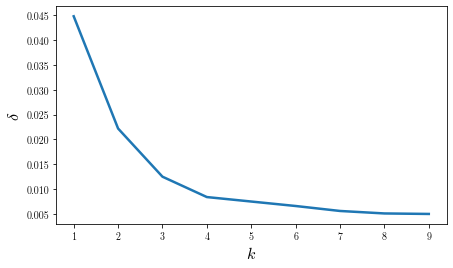

In [30]:
n_qubits = 4
n_layers = 3
shots = 1000
t = 1
ks = [i for i in range(1, 10)]
J = 1
h = 1

n_instances = 10
seeds = random.sample(range(int(1e10)), n_instances)
state_tensor_networks = [heas_ansatz_eff(n_qubits, n_layers) for i in range(n_instances)]

difs = []
for k in ks:
    difs_local = []
    for i in range(n_instances):
        p_approx, p_exact = uni_cost(n_qubits, state_tensor_networks[i], shots=shots, t=t, k=k, J=J, h=h, seed=seeds[i])
        difs_local.append(abs(p_approx - p_exact))
    difs.append(np.mean(difs_local))
    
plt.figure(figsize=(7, 4))
plt.plot(ks, difs, label='$energy$', linewidth=2.5)
plt.xlabel(r'$k$', fontsize=16)
plt.ylabel(r'$\delta$', fontsize=16)
plt.show()

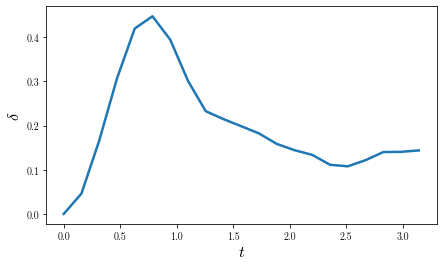

In [10]:
n_qubits = 2
n_layers = 1
shots = 1000
ts = np.linspace(0, pi, 21)
k = 1
J = 1
h = 1

n_instances = 50
seeds = random.sample(range(int(1e10)), n_instances)
state_tensor_networks = [heas_ansatz_eff(n_qubits, n_layers) for i in range(n_instances)]

difs = []
for t in ts:
    difs_local = []
    for i in range(n_instances):
        p_approx, p_exact = uni_cost(n_qubits, state_tensor_networks[i], shots=shots, t=t, k=k, J=J, h=h, seed=seeds[i])
        difs_local.append(abs(p_approx - p_exact))
    difs.append(np.mean(difs_local))
    
plt.figure(figsize=(7, 4))
plt.plot(ts, difs, label='$energy$', linewidth=2.5)
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel(r'$\delta$', fontsize=16)
plt.show()

# v2

In [7]:
from qiskit.aqua.operators.primitive_ops import MatrixOp
from qiskit.aqua.operators.evolutions import Suzuki, Trotter
from qiskit.aqua.operators.list_ops import SummedOp

In [8]:
def string_to_matrix(operator_string):
    
    qubits_number = len(operator_string)

    if operator_string[0] == 'I':
        operator = I_np
    elif operator_string[0] == 'X':
        operator = X_np
    elif operator_string[0] == 'Y':
        operator = Y_np
    elif operator_string[0] == 'Z':
        operator = Z_np

    for k in range(1, qubits_number):
        if operator_string[k] == 'I':
            operator = kron(operator, I_np)
        elif operator_string[k] == 'X':
            operator = kron(operator, X_np)
        elif operator_string[k] == 'Y':
            operator = kron(operator, Y_np)
        elif operator_string[k] == 'Z':
            operator = kron(operator, Z_np)
            
    return operator

In [9]:
def hermitian_trotterizer(qreg, creg, hermitian_dict, t=1, reps=1, order=2, method='Trotter'):
    
    sum_op = []
    for operator_string, multiplier in hermitian_dict.items():
        sum_op.append(MatrixOp(t * multiplier * string_to_matrix(operator_string)))
    sum_op = SummedOp(sum_op)
    
    if method == 'Trotter':
        operator = Trotter(reps=reps).convert(sum_op)
    if method == 'Suzuki':
        operator = Suzuki(reps=reps, order=order).convert(sum_op) 
    
    n_qubits = qreg.size
    
    circuit = QuantumCircuit(qreg, creg)
    circuit.append(operator, [i for i in range(n_qubits)])
    
    return circuit

In [10]:
def hermitian_evolution(qreg, creg, hermitian_dict, t=1):
    
    n_qubits = qreg.size
    
    circuit = QuantumCircuit(qreg, creg)
    matrix = expm(-1j * t * hamiltonian_dictionary_to_matrix(hermitian_dict))
    circuit.append(Operator(matrix), [i for i in range(n_qubits)])
    
    return circuit

In [11]:
def uni_cost_2(n_qubits, state_tensor_network, shots, t=1, reps=1, order=2, method='Trotter', seed=None):
    
    qreg = QuantumRegister(n_qubits)
    creg = ClassicalRegister(n_qubits)

    ansatz = tensor_network_to_qiskit_circuit(n_qubits, state_tensor_network, qreg, creg)
    ansatz_dg = (tensor_network_to_qiskit_circuit(n_qubits, state_tensor_network, qreg, creg)).inverse()
    
    u_circ_approx = hermitian_trotterizer(qreg, creg, hermitian_dict, t=t, reps=reps, order=order, method=method)
    u_circ_exact = hermitian_evolution(qreg, creg, hermitian_dict, t=t)
    
    measurer = QuantumCircuit(qreg, creg)
    for i in range(n_qubits):
        measurer.measure(i, i)
    
    circuit_approx = ansatz + u_circ_approx + ansatz_dg + measurer
    circuit_exact = ansatz + u_circ_exact + ansatz_dg + measurer
    
    job = execute([circuit_approx, circuit_exact], shots=shots, seed_simulator=seed, backend=Aer.get_backend('qasm_simulator'))   
    result = job.result()
    counts = result.get_counts()
    
    zeros_str = '0' * n_qubits
    if zeros_str in counts[0].keys():
        p0_approx = counts[0][zeros_str] / shots
    else:
        p0_approx = 0
    if zeros_str in counts[1].keys():
        p0_exact = counts[1][zeros_str] / shots
    else:
        p0_exact = 0
    
    return p0_approx, p0_exact

In [59]:
n_qubits = 4
n_layers = 3
shots = 1000
t = 1
reps = 1
order = 2
method = 'Suzuki'

hermitian_dict = ising_model(n_qubits, 1, 1)
state_tensor_network = heas_ansatz_eff(n_qubits, n_layers)

uni_cost_2(n_qubits, state_tensor_network, shots=shots, t=t, reps=reps, order=order, method=method, seed=None)

(0.058, 0.001)

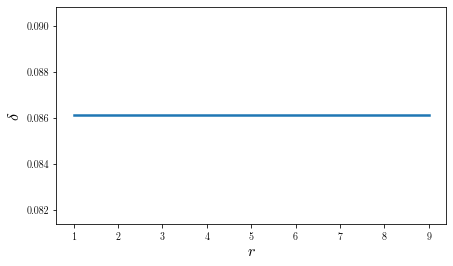

In [61]:
n_qubits = 4
n_layers = 3
shots = 1000
t = 1
reps_list = [i for i in range(1, 10)]
order = 2
method = 'Trotter'

hermitian_dict = ising_model(n_qubits, 1, 1)

n_instances = 10
seeds = random.sample(range(int(1e10)), n_instances)
state_tensor_networks = [heas_ansatz_eff(n_qubits, n_layers) for i in range(n_instances)]

difs = []
for reps in reps_list:
    difs_local = []
    for i in range(n_instances):
        p_approx, p_exact = uni_cost_2(n_qubits, state_tensor_networks[i], shots=shots, t=t, reps=reps, order=order, method=method, seed=seeds[i])
        difs_local.append(abs(p_approx - p_exact))
    difs.append(np.mean(difs_local))
    
plt.figure(figsize=(7, 4))
plt.plot(reps_list, difs, label='$energy$', linewidth=2.5)
plt.xlabel(r'$r$', fontsize=16)
plt.ylabel(r'$\delta$', fontsize=16)
plt.show()

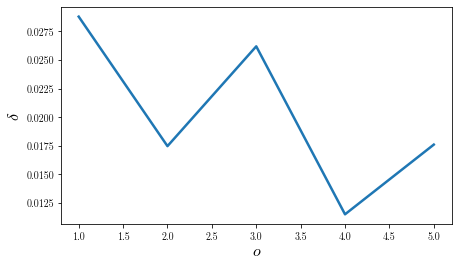

In [62]:
n_qubits = 4
n_layers = 3
shots = 1000
t = 1
reps = 3
order_list = [i for i in range(1, 6)]
method = 'Suzuki'

hermitian_dict = ising_model(n_qubits, 1, 1)

n_instances = 30
seeds = random.sample(range(int(1e10)), n_instances)
state_tensor_networks = [heas_ansatz_eff(n_qubits, n_layers) for i in range(n_instances)]

difs = []
for order in order_list:
    difs_local = []
    for i in range(n_instances):
        p_approx, p_exact = uni_cost_2(n_qubits, state_tensor_networks[i], shots=shots, t=t, reps=reps, order=order, method=method, seed=seeds[i])
        difs_local.append(abs(p_approx - p_exact))
    difs.append(np.mean(difs_local))
    
plt.figure(figsize=(7, 4))
plt.plot(order_list, difs, label='$energy$', linewidth=2.5)
plt.xlabel(r'$o$', fontsize=16)
plt.ylabel(r'$\delta$', fontsize=16)
plt.show()

# v3

In [133]:
from qiskit.aqua.operators.primitive_ops import MatrixOp
from qiskit.aqua.operators.evolutions import Suzuki, Trotter
from qiskit.aqua.operators.list_ops import SummedOp

In [132]:
def string_to_matrix(operator_string):
    
    qubits_number = len(operator_string)

    if operator_string[0] == 'I':
        operator = I_np
    elif operator_string[0] == 'X':
        operator = X_np
    elif operator_string[0] == 'Y':
        operator = Y_np
    elif operator_string[0] == 'Z':
        operator = Z_np

    for k in range(1, qubits_number):
        if operator_string[k] == 'I':
            operator = kron(operator, I_np)
        elif operator_string[k] == 'X':
            operator = kron(operator, X_np)
        elif operator_string[k] == 'Y':
            operator = kron(operator, Y_np)
        elif operator_string[k] == 'Z':
            operator = kron(operator, Z_np)
            
    return operator

In [147]:
def hermitian_trotterizer(qreg, creg, hermitian_dict, t=1, reps=1, order=2):
    
    sum_op = []
    for operator_string, multiplier in hermitian_dict.items():
        sum_op.append(MatrixOp(t * multiplier * string_to_matrix(operator_string)))
    sum_op = SummedOp(sum_op)
    
    operator = Suzuki(reps=reps, order=order).convert(sum_op) 
    
    n_qubits = qreg.size
    
    circuit = QuantumCircuit(qreg, creg)
    circuit.append(operator, [i for i in range(n_qubits)])
    
    pass_ = Unroller(['u1', 'u2', 'u3', 'rzz', 'cx'])
    pm = PassManager(pass_)
    new_circ = pm.run(circuit)
    new_circ = transpile(new_circ, optimization_level=3)
    
#     return circuit
    return new_circ

In [148]:
def hermitian_evolution(qreg, creg, hermitian_dict, t=1):
    
    n_qubits = qreg.size
    
    circuit = QuantumCircuit(qreg, creg)
    matrix = expm(-1j * t * hamiltonian_dictionary_to_matrix(hermitian_dict))
    circuit.append(Operator(matrix), [i for i in range(n_qubits)])
    
    return circuit

In [149]:
def uni_cost_2(n_qubits, hermitian_dict, state_tensor_network, shots, t=1, reps=1, order=2, seed=None):
    
    qreg = QuantumRegister(n_qubits)
    creg = ClassicalRegister(n_qubits)

    ansatz = tensor_network_to_qiskit_circuit(n_qubits, state_tensor_network, qreg, creg)
    ansatz_dg = (tensor_network_to_qiskit_circuit(n_qubits, state_tensor_network, qreg, creg)).inverse()
    
    u_circ_approx = hermitian_trotterizer(qreg, creg, hermitian_dict, t=t, reps=reps, order=order)
    u_circ_exact = hermitian_evolution(qreg, creg, hermitian_dict, t=t)
    
    measurer = QuantumCircuit(qreg, creg)
    for i in range(n_qubits):
        measurer.measure(i, i)
    
    circuit_approx = ansatz + u_circ_approx + ansatz_dg + measurer
    circuit_exact = ansatz + u_circ_exact + ansatz_dg + measurer
    
    job = execute([circuit_approx, circuit_exact], shots=shots, seed_simulator=seed, backend=Aer.get_backend('qasm_simulator'))   
    result = job.result()
    counts = result.get_counts()
    
    zeros_str = '0' * n_qubits
    if zeros_str in counts[0].keys():
        p0_approx = counts[0][zeros_str] / shots
    else:
        p0_approx = 0
    if zeros_str in counts[1].keys():
        p0_exact = counts[1][zeros_str] / shots
    else:
        p0_exact = 0
    
    return p0_approx, p0_exact

In [150]:
n_qubits = 4
n_layers = 3
shots = 1000
t = 1
reps = 2
order = 2

hermitian_dict = ising_model(n_qubits, 1, 1)
state_tensor_network = heas_ansatz_eff(n_qubits, n_layers)

uni_cost_2(n_qubits, hermitian_dict, state_tensor_network, shots=shots, t=t, reps=reps, order=order, seed=None)

(0.01, 0.031)

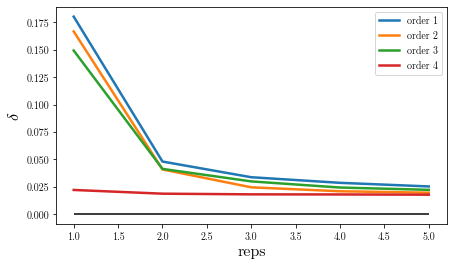

In [151]:
n_qubits = 2
n_layers = 1
shots = 1000
t = 1
reps_list = [i for i in range(1, 6)]
order_list = [i for i in range(1, 5)]

hermitian_dict = ising_model(n_qubits, 1, 1)

n_instances = 10
seeds = random.sample(range(int(1e10)), n_instances)
state_tensor_networks = [heas_ansatz_eff(n_qubits, n_layers) for i in range(n_instances)]

difs_global = []
for order in order_list:
    difs = []
    for reps in reps_list:
        difs_local = []
        for i in range(n_instances):
            p_approx, p_exact = uni_cost_2(n_qubits, hermitian_dict, state_tensor_networks[i], shots=shots, t=t, reps=reps, order=order, seed=seeds[i])
            difs_local.append(abs(p_approx - p_exact))
        difs.append(np.mean(difs_local))
    difs_global.append(difs)
    
plt.figure(figsize=(7, 4))
for i in range(len(difs_global)):
    plt.plot(reps_list, difs_global[i], label='order ' + str(order_list[i]), linewidth=2.5)
plt.xlabel(r'reps', fontsize=16)
plt.ylabel(r'$\delta$', fontsize=16)
plt.hlines(xmin=reps_list[0], xmax=reps_list[-1], y=0)
plt.legend()
plt.show()

# Comparison

In [58]:
def ising_unitary_trotter(qreg, creg, t, k, J=1, h=1):
    
    n_qubits = qreg.size
    
    T = 2 * t / k
    
    circuit = QuantumCircuit(qreg, creg)
    
    for i in range(k):
        for j in range(n_qubits - 1):
            circuit.rzz(J * T, j, j + 1)
        if n_qubits > 2:
            circuit.rzz(J * T, 0, n_qubits - 1)
        for j in range(n_qubits):
            circuit.rx(h * T, j)

    return circuit

In [59]:
def ising_unitary_exact(qreg, creg, t, J=1, h=1):
    
    n_qubits = qreg.size
    
    circuit = QuantumCircuit(qreg, creg)
    matrix = expm(-1j * t * hamiltonian_dictionary_to_matrix(ising_model(n_qubits, J, h)))
    circuit.append(Operator(matrix), [i for i in range(n_qubits)])
    
    return circuit

In [333]:
def uni_cost(n_qubits, state_tensor_network, shots, t, k, J=1, h=1, seed=None):
    
    qreg = QuantumRegister(n_qubits)
    creg = ClassicalRegister(n_qubits)

    ansatz = tensor_network_to_qiskit_circuit(n_qubits, state_tensor_network, qreg, creg)
    ansatz_dg = ansatz.inverse()#(tensor_network_to_qiskit_circuit(n_qubits, state_tensor_network, qreg, creg)).inverse()
    
    u_circ_approx = ising_unitary_trotter(qreg, creg, t, k, J=J, h=h)
    u_circ_exact = ising_unitary_exact(qreg, creg, t, J=J, h=h) 
    
    measurer = QuantumCircuit(qreg, creg)
    for i in range(n_qubits):
        measurer.measure(i, i)
    
    circuit_approx = ansatz + u_circ_approx + ansatz_dg + measurer
    circuit_exact = ansatz + u_circ_exact + ansatz_dg
    
#     print('\t uni gate count:', circuit_approx.size() - measurer.size())
    
    job = execute(circuit_approx, shots=shots, seed_simulator=seed, backend=Aer.get_backend('qasm_simulator'))   
    result = job.result()
    counts = result.get_counts()
    
    zeros_str = '0' * n_qubits
    if zeros_str in counts.keys():
        p0_approx = counts[zeros_str] / shots
    else:
        p0_approx = 0
        
    job = execute(circuit_exact, backend=Aer.get_backend('unitary_simulator'))   
    result = job.result()
    u = result.get_unitary()
    
    zerostate = np.array([1] + [0]*(2**n_qubits - 1))
    p0_exact = abs( (zerostate.conj().T).dot(u).dot(zerostate) )**2
    
    return p0_approx, p0_exact

In [80]:
def decompose_to_paulies(n_qubits, hermitian):
    
    d = 2**n_qubits
    
    hermitian_dict = {}
    
    paulies = ['I', 'X', 'Y', 'Z']
    bases = list(product(*[paulies for i in range(n_qubits)]))
    
    for basis in bases:
        observable = string_to_matrix(basis)
        result = trace(hermitian.dot(observable)).real
        
        if result != 0:
            label = ''.join(basis) # strange pythonic thing for concatinating chars in a list
            hermitian_dict[label] = result / d
    
    return hermitian_dict

In [334]:
def var_cost(n_qubits, hamiltonian_dict, hamiltonian_dict_sq, state_tensor_network, shots, t, J=1, h=1, seed=None):
    
    qreg = QuantumRegister(n_qubits)
    creg = ClassicalRegister(n_qubits)
    
    
#     hamiltonian_dict = ising_model(n_qubits, J, h)
#     ham = hamiltonian_dictionary_to_matrix(ising_model(n_qubits, J, h))
#     ham_sq = ham.dot(ham)
#     hamiltonian_dict_sq = decompose_to_paulies(n_qubits, ham_sq)
    
    gate_count_1 = 0
    
    ansatz = tensor_network_to_qiskit_circuit(n_qubits, state_tensor_network, qreg, creg)
    circuits = []
    multipliers = []
    for operator, multiplier in hamiltonian_dict.items():

        circuit = QuantumCircuit(qreg, creg)
        circuit = circuit + ansatz
        gate_count_1 += circuit.size()

        for j in range(n_qubits):
            if operator[j] == 'X':
                circuit.h(j)
                gate_count_1 += 1
            if operator[j] == 'Y':
                circuit.s(j)
                circuit.h(j)
            if operator[j] != 'I':
                circuit.measure(j, j)
                
        circuits.append(circuit)
        multipliers.append(multiplier)
#     print('\t var gate count 1:', gate_count_1)
    job = execute(circuits,
                  backend=Aer.get_backend('qasm_simulator'),
                  shots=shots)    
    result = job.result()
    counts = result.get_counts()
    
    L = len(multipliers)
    h1 = 0
    for l in range(L):
        h1_local = 0
        for key in counts[l].keys():
            h1_local += counts[l][key] * (-1)**key.count('1') / shots
        h1 += h1_local * multipliers[l]
        
    gate_count_2 = 0
    circuits = []
    multipliers = []
    for operator, multiplier in hamiltonian_dict_sq.items():

        circuit = QuantumCircuit(qreg, creg)
        circuit = circuit + ansatz
        gate_count_2 += circuit.size()

        for j in range(n_qubits):
            if operator[j] == 'X':
                circuit.h(j)
                gate_count_2 += 1
            if operator[j] == 'Y':
                circuit.s(j)
                circuit.h(j)
            if operator[j] != 'I':
                circuit.measure(j, j)
                
        circuits.append(circuit)
        multipliers.append(multiplier)
#     print('\t var gate count 2:', gate_count_2)
    job = execute(circuits,
                  backend=Aer.get_backend('qasm_simulator'),
                  shots=shots)    
    result = job.result()
    counts = result.get_counts()
    
    L = len(multipliers)
    h2 = 0
    for l in range(L):
        h2_local = 0
        for key in counts[l].keys():
            h2_local += counts[l][key] * (-1)**key.count('1') / shots
        h2 += h2_local * multipliers[l]
        
    fun_value_approx = h2 - h1**2
        
#     print('\t var gate count:', gate_count_1 + gate_count_2)
#     print()
        
    #####
        
    circuit = QuantumCircuit(qreg, creg)
    circuit = circuit + ansatz
    job = execute(circuit,
                  backend=Aer.get_backend('statevector_simulator'))    
    statevector = job.result().get_statevector()
    
    fun_value_exact = ( statevector.conj().T.dot(ham_sq).dot(statevector) - (statevector.conj().T.dot(ham).dot(statevector))**2 ).real
        
    return fun_value_approx, fun_value_exact

In [233]:
n_qubits = 2
n_layers = 1
t = 1
J = 1
h = 1
shots = 1000

hermitian_dict = ising_model(n_qubits, J, h)
ham = hamiltonian_dictionary_to_matrix(hermitian_dict)
ham_sq = ham.dot(ham)
hermitian_dict_sq = decompose_to_paulies(n_qubits, ham_sq)

state_tensor_network = heas_ansatz_eff(n_qubits, n_layers)

var_cost(n_qubits, hermitian_dict, hermitian_dict_sq, state_tensor_network, shots, t, J=J, h=h, seed=None)

	 var gate count: 45


(1.3111, 1.2915595610170418)

var gate count: 3830
uni gate count: 215
var gate count: 3830
uni gate count: 215


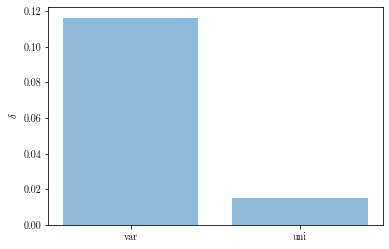

In [230]:
n_qubits = 5
n_layers = 4
J = 1
h = 1
shots = 1000
t = 1
k = 5

hermitian_dict = ising_model(n_qubits, J, h)
ham = hamiltonian_dictionary_to_matrix(hermitian_dict)
ham_sq = ham.dot(ham)
hermitian_dict_sq = decompose_to_paulies(n_qubits, ham_sq)

n_instances = 2
seeds = random.sample(range(int(1e10)), n_instances)
state_tensor_networks = [heas_ansatz_eff(n_qubits, n_layers) for i in range(n_instances)]

var_difs = []
uni_difs = []
for i in range(n_instances):
    var_val_approx, var_val_exact = var_cost(n_qubits, hermitian_dict, hermitian_dict_sq, state_tensor_networks[i], shots, t=t, J=J, h=h, seed=seeds[i])
    uni_val_approx, uni_val_exact = uni_cost(n_qubits, state_tensor_networks[i], shots, t=t, k=k, J=J, h=h, seed=seeds[i])
    var_difs.append(abs(var_val_approx - var_val_exact))# / 39.86345818680678)
    uni_difs.append(abs(uni_val_approx - uni_val_exact))
var_dif = np.mean(var_difs)
uni_dif = np.mean(uni_difs)
var_dis = np.var(var_difs)
uni_dis = np.var(uni_difs)

x = [0, 1]
y = [var_dif, uni_dif]
plt.bar(x, y, align='center', alpha=0.5)
plt.xticks(x, ['var', 'uni'])
plt.ylabel(r'$\delta$')
plt.show()

In [345]:
from scipy.stats import sem

from matplotlib import rc, gridspec
matplotlib.rc('font', family='CMU Serif')
matplotlib.rcParams['mathtext.fontset'] = 'cm' 
matplotlib.rcParams['axes.unicode_minus'] = False

In [375]:
n_qubits = 5
n_layers = 4
J = 1
h = 1
shots = 1000
t = 1
ks = [i for i in range(1, 11)]

hermitian_dict = ising_model(n_qubits, J, h)
ham = hamiltonian_dictionary_to_matrix(hermitian_dict)
ham_sq = ham.dot(ham)
hermitian_dict_sq = decompose_to_paulies(n_qubits, ham_sq)

n_instances = 300
seeds = random.sample(range(int(1e10)), n_instances)
state_tensor_networks = [hea_ansatz_eff(n_qubits, n_layers) for i in range(n_instances)]


x0 = [random.uniform(0, 2*pi) for i in range(2**(n_qubits + 1))]
args = (ham)
method = 'BFGS'
res = minimize(fun, x0, args, method)
normalizer = abs(res.fun)


var_difs = []
for i in range(n_instances):
    var_val_approx, var_val_exact = var_cost(n_qubits, hermitian_dict, hermitian_dict_sq, state_tensor_networks[i], shots, t=t, J=J, h=h, seed=seeds[i])
    var_difs.append(abs(var_val_approx - var_val_exact) / normalizer)
var_std = sem(var_difs)
var_dis = np.var(var_difs)
var_dif = np.mean(var_difs) 


uni_difs_k = []
uni_diss_k = []
uni_stds_k = []
for k in ks:
    print(k)
    uni_difs = []
    for i in range(n_instances):
        uni_val_approx, uni_val_exact = uni_cost(n_qubits, state_tensor_networks[i], shots, t=t, k=k, J=J, h=h, seed=seeds[i])
        uni_difs.append(abs(uni_val_approx - uni_val_exact))
    uni_difs_k.append(np.mean(uni_difs))
    uni_diss_k.append(np.var(uni_difs))
    uni_stds_k.append(sem(uni_difs))

1
2
3
4
5
6
7
8
9
10


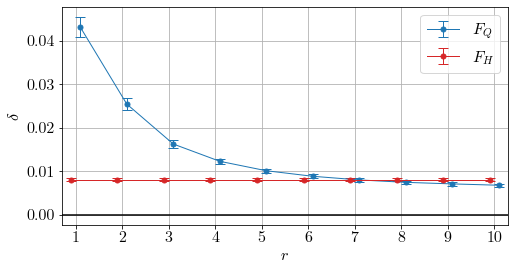

In [379]:
dif = (ks[1] - ks[0]) / 10
l = len(ks)

plt.figure(figsize=(8, 4))
plt.errorbar(np.array(ks) + dif, uni_difs_k, yerr=uni_stds_k, color='tab:blue', label=r'$F_Q$', fmt='o-', capsize=5, linewidth=1, markersize=5)
plt.errorbar(np.array(ks) - dif, [var_dif]*l, yerr=[var_std]*l, color='tab:red', label=r'$F_H$', fmt='o-', capsize=5, linewidth=1, markersize=5)
plt.hlines(y=0, xmin=ks[0]-0.3, xmax=ks[-1]+0.3, colors='black', linestyles='solid')
plt.legend(fontsize=16)
plt.grid()
plt.xlim(ks[0]-0.3, ks[-1]+0.3)
plt.xticks(ks, fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r'$r$', fontsize=16)
plt.ylabel(r'$\delta$', fontsize=16)
plt.savefig(str(n_qubits) + 'q-' + str(n_instances) + 'n' + '-delta_k.png', bbox_inches='tight')
plt.savefig(str(n_qubits) + 'q-' + str(n_instances) + 'n' + '-delta_k.pdf', bbox_inches='tight')
plt.show()